# **Project Name**    - Air Quality (multiclassification/regresion/NN)
##### **Data**            - https://www.kaggle.com/datasets/rabieelkharoua/air-quality-and-health-impact-dataset/data

This project addresses the challenge of assessing the health impact of air pollution using machine learning techniques. Both classification and regression models were developed and evaluated to predict health outcomes based on various air quality indicators.

HealthImpactScore: A score indicating the overall health impact based on air quality and other related factors, ranging from 0 to 100.

HealthImpactClass: Classification of the health impact based on the HealthImpactScore

# Imports

In [ ]:
import time
import pickle
import random
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import (
    StratifiedShuffleSplit,
    StratifiedKFold,
    KFold,
    RandomizedSearchCV,
)
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.pipeline import Pipeline

# Classification models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Regression models
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# Model evaluation metrics
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
    mean_absolute_error,
    mean_squared_error,
    r2_score,
)

# Feature selection
from boruta import BorutaPy

# Visualization
from yellowbrick import ClassBalance

# Deep learning
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, LeakyReLU

# Dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Model explainability
import shap

In [13]:
def set_global_seed(seed):
    """Sets global seed for reproducibility."""
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    print(f"Global seed set to: {seed}")


SEED = 42
set_global_seed(SEED)

Global seed set to: 42


In [6]:
def rmse(y_true, y_pred):
    """Calculate root mean squared error."""
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [ ]:
# Warnings removed for decluttering code output
warnings.filterwarnings("ignore", category=FitFailedWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings(
    "ignore",
    message="X does not have valid feature names, but LGBMClassifier was fitted with feature names"
)

# Data Load

In [ ]:
def load_data(file_path):
    """Load the dataset from a specified file path."""
    try:
        df = pd.read_csv(file_path, index_col=0)
        df = df.reset_index(drop=True)
        return df
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

In [110]:
file_path = "https://raw.githubusercontent.com/Zanyata/Air_Quality/refs/heads/main/data/air_quality_health_impact_data.csv"
df = load_data(file_path)

# Check classification correctness

HealthImpactClass: Classification of the health impact based on the HealthImpactScore:

0: 'Very High' (HealthImpactScore >= 80)

1: 'High' (60 <= HealthImpactScore < 80)

2: 'Moderate' (40 <= HealthImpactScore < 60)

3: 'Low' (20 <= HealthImpactScore < 40)

4: 'Very Low' (HealthImpactScore < 20)

In [ ]:
# Creating bins for comparison with existing labels
bins = [0, 20, 40, 60, 80, 100]
bin_labels = [4, 3, 2, 1, 0]
df["Bins"] = pd.cut(df["HealthImpactScore"], bins=bins, labels=bin_labels)
df["Bins"] = df["Bins"].astype("float64")

In [ ]:
# Comparing existing labels with correct labels
print(df.shape, df[df["HealthImpactClass"] == df["Bins"]].shape)
print(df.shape[0] - df[df["HealthImpactClass"] == df["Bins"]].shape[0])
df = df.drop(columns="Bins")

(5811, 15) (5580, 15)
231


We see that 231 (~4%) cases are wrongly categorized and should be fixed.

Also the size of dataset shows that is is small dataset, which suggests using complex models might be not effective.

In [111]:
def classification_correction(df):
    """Corrects labeling"""
    bins = [0, 20, 40, 60, 80, 100]
    bin_labels = [4, 3, 2, 1, 0]
    df["HealthImpactClass"] = pd.cut(
        df["HealthImpactScore"], bins=bins, labels=bin_labels
    )
    df["HealthImpactClass"] = df["HealthImpactClass"].astype("float64")
    return df

In [112]:
df = classification_correction(df)

# Classification
Classificaton using HealthImpactClass

## EDA

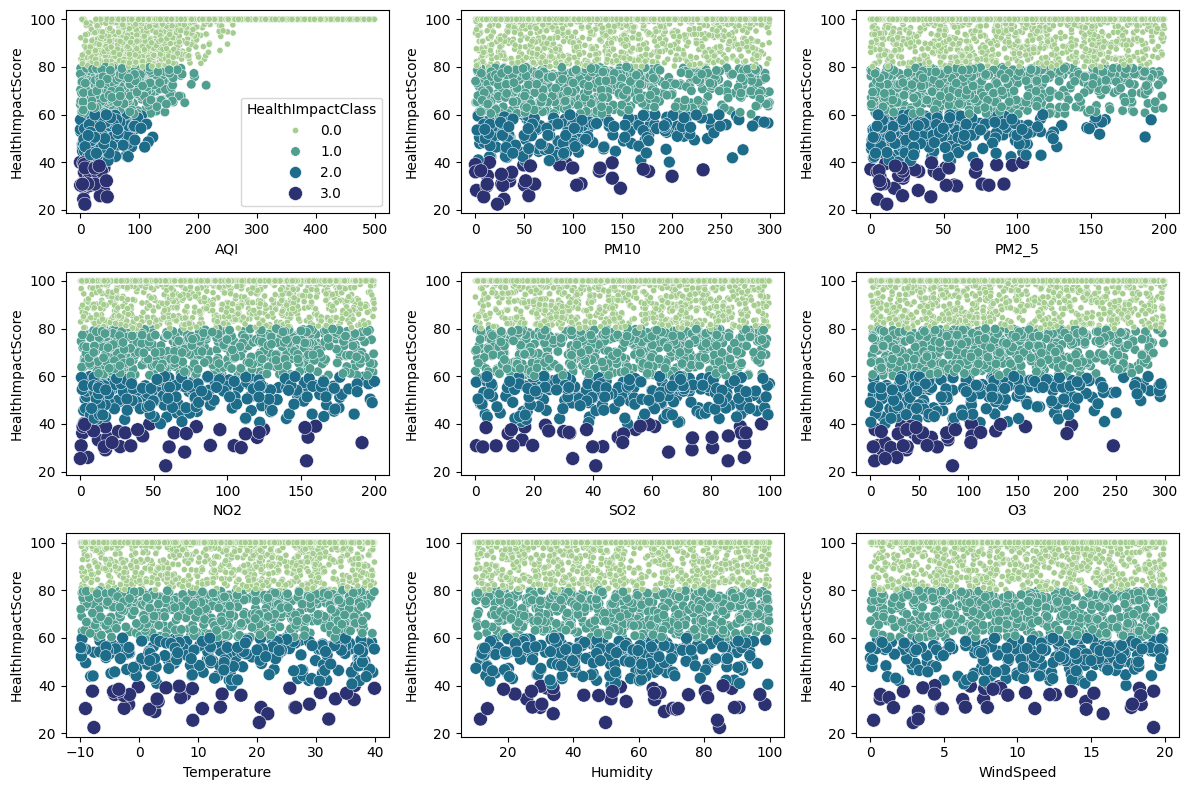

In [ ]:
target = "HealthImpactScore"
predictors = [
    "AQI",
    "PM10",
    "PM2_5",
    "NO2",
    "SO2",
    "O3",
    "Temperature",
    "Humidity",
    "WindSpeed",
]
plt.figure(figsize=(12, 8))
for i, var in enumerate(df[predictors]):
    plt.subplot(3, 3, i + 1)
    sns.scatterplot(
        data=df,
        x=var,
        y=target,
        hue="HealthImpactClass",
        size="HealthImpactClass",
        sizes=(20, 100),
        legend=i == 0,
        palette="crest",
    )
plt.tight_layout()
plt.show()

Health impact increases with increasing air polution. Atmospherical conditions (temperature, humidity, wind speed) doesn't seem to have a correlation with HealthImpactScore or Class.

Plot shows visible non-linear trends in multiple features, some saturation zones (e.g., HealthImpactScore flattens out for high AQI). -> favoring tree-based or kernel models

In [173]:
# Dropping columnn for regression task
df = df.drop(columns="HealthImpactScore")

In [80]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5811 entries, 0 to 5810
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   AQI                  5811 non-null   float64
 1   PM10                 5811 non-null   float64
 2   PM2_5                5811 non-null   float64
 3   NO2                  5811 non-null   float64
 4   SO2                  5811 non-null   float64
 5   O3                   5811 non-null   float64
 6   Temperature          5811 non-null   float64
 7   Humidity             5811 non-null   float64
 8   WindSpeed            5811 non-null   float64
 9   RespiratoryCases     5811 non-null   int64  
 10  CardiovascularCases  5811 non-null   int64  
 11  HospitalAdmissions   5811 non-null   int64  
 12  HealthImpactClass    5811 non-null   float64
dtypes: float64(10), int64(3)
memory usage: 590.3 KB


In [81]:
df.duplicated().value_counts()

False    5811
Name: count, dtype: int64

No duplicates, no null, only numerical values

In [ ]:
# Check whether columns are binary
for column in df:

    if len(df[column].value_counts()) < 3:

        print(df[column].value_counts())

No binary features

In [92]:
df.select_dtypes("object").nunique().sort_values() 

Series([], dtype: float64)

No categorical data, CatBoost LightGBM aren't very advantageus for this dataset.

In [83]:
df.describe()

,AQI,PM10,PM2_5,NO2,SO2,O3,Temperature,Humidity,WindSpeed,RespiratoryCases,CardiovascularCases,HospitalAdmissions,HealthImpactClass
count,5811.000000,5811.000000,5811.000000,5811.000000,5811.000000,5811.000000,5811.000000,5811.000000,5811.000000,5811.000000,5811.000000,5811.000000,5811.000000
mean,248.438476,148.654997,100.223714,102.293445,49.456838,149.312431,14.975500,54.776853,9.989177,9.974187,4.988986,2.001033,0.191189
std,144.777638,85.698500,58.096612,57.713175,28.530329,86.534240,14.483067,26.020786,5.776950,3.129234,2.216791,1.398794,0.521250
min,0.005817,0.015848,0.031549,0.009625,0.011023,0.001661,-9.990998,10.001506,0.002094,1.000000,0.000000,0.000000,0.000000
25%,122.951293,75.374954,49.435171,53.538538,24.887264,73.999665,2.481500,31.995262,4.952343,8.000000,3.000000,1.000000,0.000000
50%,249.127841,147.634997,100.506337,102.987736,49.530165,149.559871,14.942428,54.543904,10.051742,10.000000,5.000000,2.000000,0.000000
75%,373.630668,222.436759,151.340260,151.658516,73.346617,223.380126,27.465374,77.641639,14.971840,12.000000,6.000000,3.000000,0.000000
max,499.858837,299.901962,199.984965,199.980195,99.969561,299.936812,39.963434,99.997493,19.999139,23.000000,14.000000,12.000000,3.000000


### Data Distribution Analysis

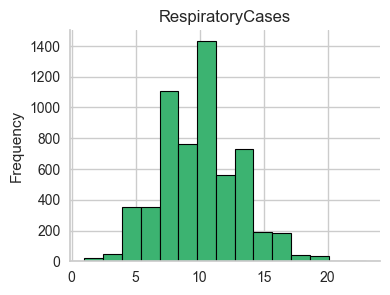

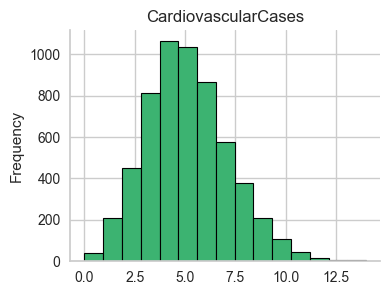

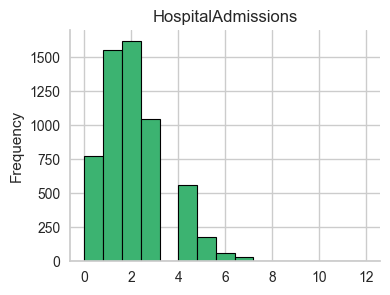

In [ ]:
# Histogram to visualize the data distribution

cols = ["RespiratoryCases", "CardiovascularCases", "HospitalAdmissions"]

for col in cols:
    plt.figure(figsize=(4, 3))
    df[col].plot(
        kind="hist",
        bins=15,
        title=col,
        color="mediumseagreen",
        edgecolor="black",
        linewidth=0.8,
    )
    plt.gca().spines[
        [
            "top",
            "right",
        ]
    ].set_visible(False)
    plt.show()

RespiratoryCases have rather normal distribution, CardiovascularCases is slighly right-skewed, HospitalAdmissions is right-skewed.

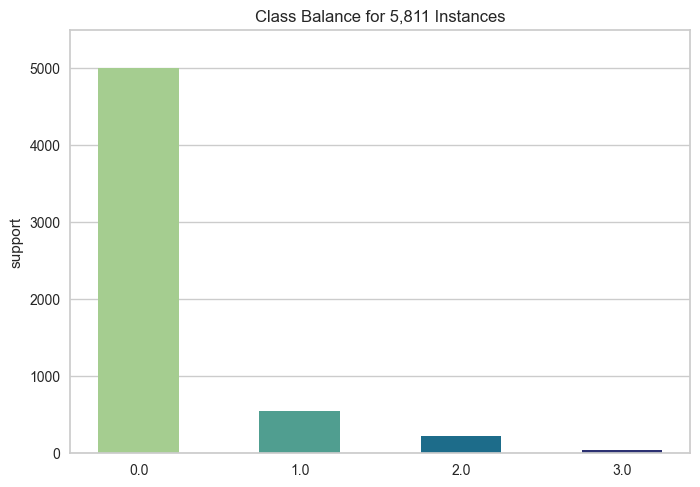

<Axes: title={'center': 'Class Balance for 5,811 Instances'}, ylabel='support'>

In [55]:
# Visualization of class distribution
visualizer = ClassBalance(colormap="crest")
visualizer.fit(df["HealthImpactClass"])
visualizer.show()

Imbalanced dataset, this needs to be taken in to concideration while preparing train and test splits and further model training.

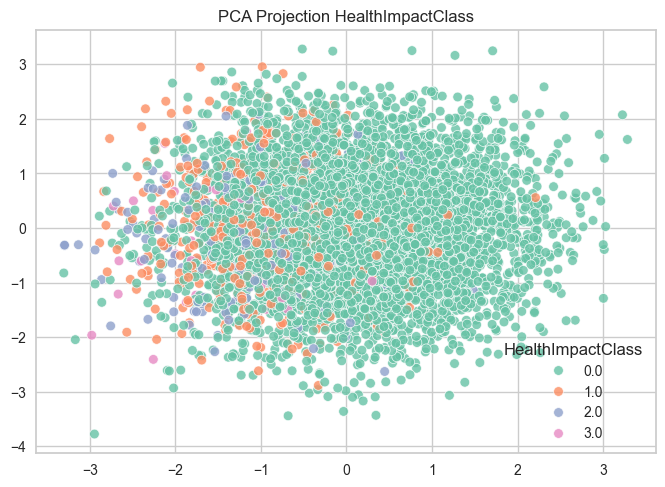

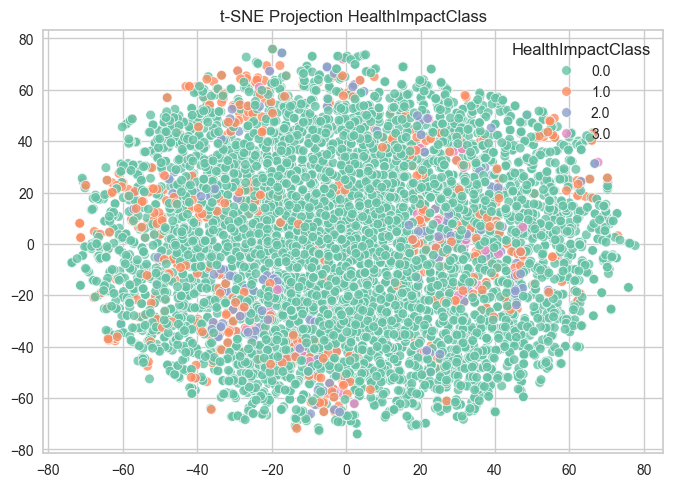

In [ ]:
def visualize_dimensionality_reduction(df, target_col):
    """Visualize separability using PCA and t-SNE."""
    features = df.drop(columns=["HealthImpactScore", "HealthImpactClass"])
    y = df[target_col]
    X_scaled = StandardScaler().fit_transform(features.select_dtypes(include=np.number))

    # PCA projection
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)
    sns.scatterplot(
        x=X_pca[:, 0],
        y=X_pca[:, 1],
        hue=y,
        palette="Set2",
        alpha=0.8,
        edgecolor="white",
    )
    plt.title(f"PCA Projection {y.name}")
    plt.show()

    # t-SNE projection
    tsne = TSNE(n_components=2, perplexity=30, learning_rate=200)
    X_tsne = tsne.fit_transform(X_scaled)
    sns.scatterplot(
        x=X_tsne[:, 0],
        y=X_tsne[:, 1],
        hue=y,
        palette="Set2",
        alpha=0.8,
        edgecolor="white",
    )
    plt.title(f"t-SNE Projection {y.name}")
    plt.show()


visualize_dimensionality_reduction(df, "HealthImpactClass")

**PCA**

* No clear cluster boundaries between classes.

* Suggests poor linear separability → linear models like logistic regression may struggle.

**t-SNE** 

* Slight improvement in separability (e.g., denser cluster centers).

* Tree-based or non-linear models (SVM, RF, boosting) likely more effective.

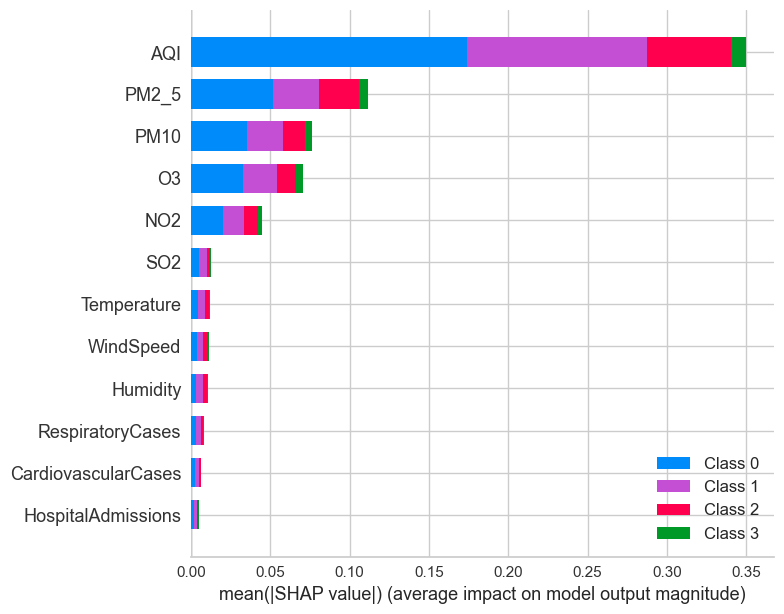

In [175]:
def plot_shap_summary(df, target_col):
    """Plot SHAP summary for a tree-based model."""
    features = df.drop(columns=[target_col])
    y = df[target_col]
    X_scaled = StandardScaler().fit_transform(features.select_dtypes(include=np.number))
    model = RandomForestClassifier().fit(X_scaled, y)
    explainer = shap.Explainer(model)
    shap_values = explainer(X_scaled)
    shap.summary_plot(shap_values, features, rng=SEED)


plot_shap_summary(df, "HealthImpactClass")

**SHAP Summary**

* AQI, PM2.5, PM10 dominate feature importance.

* Lower-ranked features have minimal contribution → possible candidates for dropping or further feature engineering.

The most informative features are: AQI, PM10, PM2_5, NO2, O3. 

* AQI: Air Quality Index, a measure of how polluted the air currently is or how polluted it is forecast to become.

* PM10: Concentration of particulate matter less than 10 micrometers in diameter (μg/m³).

* PM2_5: Concentration of particulate matter less than 2.5 micrometers in diameter (μg/m³).

* O3: Concentration of ozone (ppb).

<Axes: >

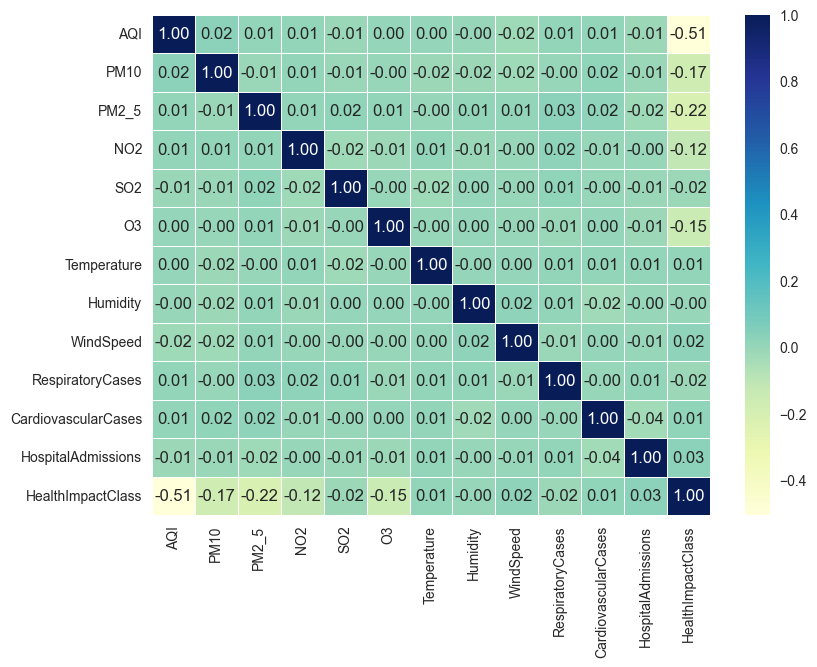

In [256]:
# Correlation Heatmap
plt.figure(figsize=(9, 6.5))
sns.heatmap(df.corr(), annot=True, linewidths=0.5, fmt=".2f", cmap="YlGnBu")

The correlation heatmap reveals a moderate negative correlation between the target variable HealthImpactClass and AQI (−0.51), suggesting that as AQI increases, the class label tends to decrease (or vice versa, depending on class encoding). Additionally, there are weak to moderate negative correlations with PM2_5, PM10, O3, and NO2.

Most of the remaining features show very weak or negligible correlations with the target.

Furthermore, there is no evidence of strong multicollinearity among the independent features (no values close to ±1 between feature pairs), which is favorable for most machine learning models, especially linear ones.

### Outliers

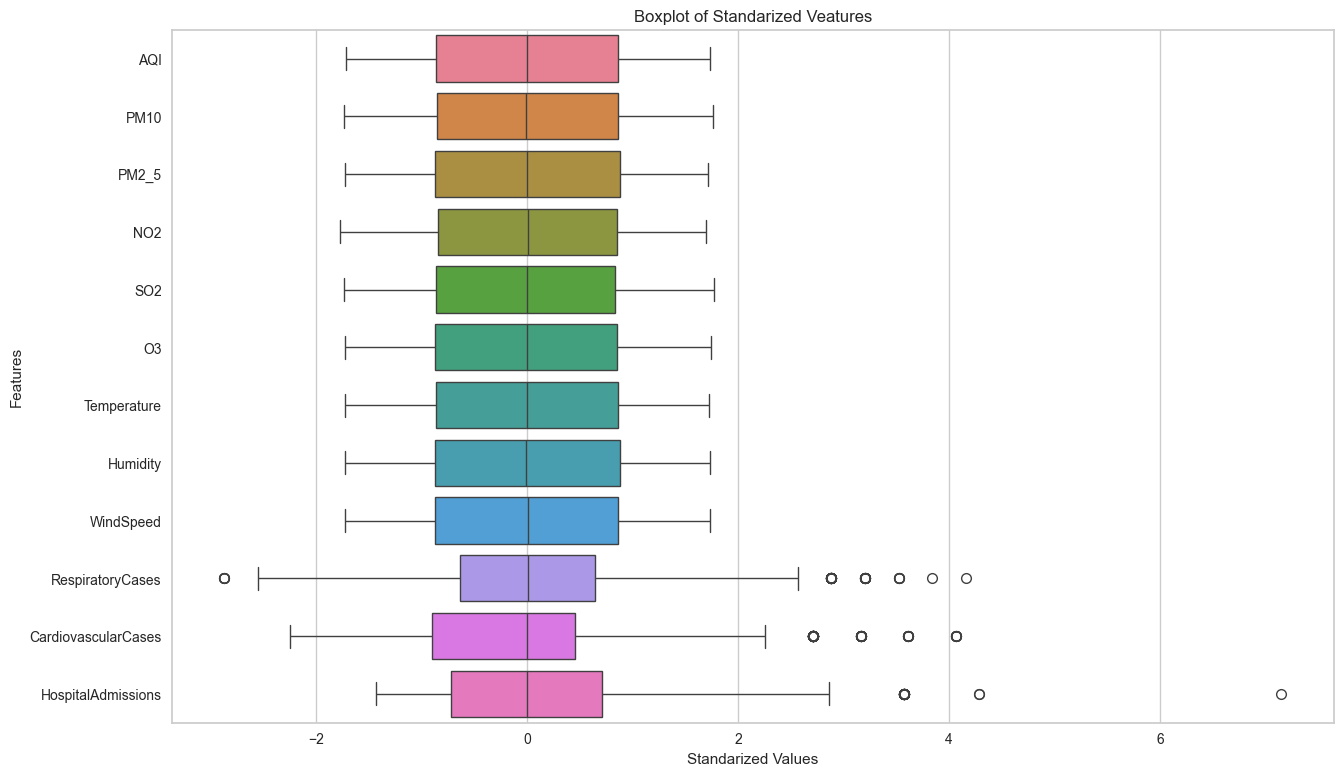

In [ ]:
# Outliers visualization
sc = StandardScaler()
labels = df.drop(columns="HealthImpactClass").columns
df_sc = sc.fit_transform(df.iloc[:, :-1])
plt.figure(figsize=(15, 9))
sns.boxplot(data=df_sc, orient="h")
plt.yticks(ticks=range(len(labels)), labels=labels)
plt.xlabel("Standarized Values")
plt.ylabel("Features")
plt.title("Boxplot of Standarized Veatures")
plt.show()

Most features, especially air quality indicators (e.g., AQI, PM10, PM2_5, NO2, O3), fall within a relatively narrow and symmetric range after standardization.

A few features — particularly:
* RespiratoryCases
* CardiovascularCases
* HospitalAdmissions

— show noticeable positive outliers (beyond 3 standard deviations), and in some cases slight negative outliers.

At this stage, it is not recommended to remove them, especially before assessing model performance. 

## Splitting

In [58]:
def stratify_splitting(df):
    """
    Perform stratified splitting based on HealthImpactClass.

    Returns:
        strat_train_set (DataFrame): Training set.
        strat_test_set (DataFrame): Test set.
        feature_names (Index): List of feature column names.
    """
    split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)
    try:
        for train_index, test_index in split.split(df, df["HealthImpactClass"]):
            strat_train_set = df.iloc[train_index]
            strat_test_set = df.iloc[test_index]
        feature_names = strat_train_set.drop(
            columns=["HealthImpactScore", "HealthImpactClass"]
        ).columns
        return strat_train_set, strat_test_set, feature_names
    except Exception as e:
        print(f"Error while splitting: {e}")
        return None


def xy_splitting_scaling(strat_train_set, strat_test_set, target_col):
    """
    Split features and targets, apply standard scaling.

    Returns:
        X_train, y_train, X_test, y_test (arrays): Scaled NumPy arrays.
    """
    try:
        X_train = strat_train_set.drop(
            columns=["HealthImpactScore", "HealthImpactClass"]
        )
        y_train = strat_train_set[target_col].values
        X_test = strat_test_set.drop(columns=["HealthImpactScore", "HealthImpactClass"])
        y_test = strat_test_set[target_col].values

        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        return X_train, y_train, X_test, y_test
    except Exception as e:
        print(f"Error while xy_splitting: {e}")
        return None

In [113]:
# Dataset with corrected classes
file_path = "https://raw.githubusercontent.com/Zanyata/Air_Quality/refs/heads/main/data/air_quality_health_impact_data.csv"

df = load_data(file_path)
df = classification_correction(df)

strat_train_set, strat_test_set, feature_names = stratify_splitting(df)
X_train, y_train, X_test, y_test = xy_splitting_scaling(
    strat_train_set, strat_test_set, "HealthImpactClass"
)

In [ ]:
# Raw dataset without correcting classes - for ML performance comparison
file_path = "https://raw.githubusercontent.com/Zanyata/Air_Quality/refs/heads/main/data/air_quality_health_impact_data.csv"

df_raw = load_data(file_path)

strat_train_set_raw, strat_test_set_raw, feature_names = stratify_splitting(df_raw)
X_train_raw, y_train_raw, X_test_raw, y_test_raw = xy_splitting_scaling(
    strat_train_set_raw, strat_test_set_raw, "HealthImpactClass"
)

## ML

### Model Benchmarking

Since it is a smaller dataset, the performance of all standard models can be checked.

In [ ]:
# Define models with appropriate class weight handling
models = {
    "log": LogisticRegression(solver="lbfgs", class_weight="balanced"),  # margin-based
    "svc": SVC(
        probability=True, class_weight="balanced", random_state=SEED
    ),  # margin-based
    "rf": RandomForestClassifier(class_weight="balanced", random_state=SEED),  # Bagging
    "lgbm": LGBMClassifier(class_weight="balanced", verbose=-1),  # Boosting
    "xgb": XGBClassifier(),  # Boosting # does not have a direct parameter like scale_pos_weight for multi-class problems.
    "cat": CatBoostClassifier(verbose=0, auto_class_weights="Balanced"),  # Boosting
}

In [ ]:
def evaluate_model(models, X_train, y_train, X_test, y_test):
    """
    Evaluate classification models on test data.

    Trains models, calculates evaluation metrics (precision, recall, F1, accuracy, ROC-AUC),
    and plots confusion matrices.

    Args:
        models (dict): Dictionary of model names and instantiated models.
        X_train (array): Training feature set.
        y_train (array): Training labels.
        X_test (array): Test feature set.
        y_test (array): Test labels.
    """
    
    # Define evaluation metrics
    metrics = [precision_score, recall_score, f1_score]
    
    # Initialize storage for metrics
    scores_train = []
    scores_test = []
    
    palette = sns.cubehelix_palette(start=2, rot=0, dark=0, light=1.5, reverse=True, as_cmap=True)
    plt.figure(figsize=(10, 6))

    # Compute precision, recall, f1-score
    for i, (name, model) in enumerate(models.items()):
        model.fit(X_train, y_train)
        preds_train = model.predict(X_train)
        preds_test = model.predict(X_test)
        preds_proba_train = None

        # Compute balanced sample weights
        weights_train = compute_sample_weight(class_weight="balanced", y=y_train)
        weights_test = compute_sample_weight(class_weight="balanced", y=y_test)

        # Check if predict_proba is available
        if hasattr(model, "predict_proba"):
            preds_proba_train = model.predict_proba(X_train)
            preds_proba_test = model.predict_proba(X_test)

        # Initialize dictionaries for storing model scores
        model_scores_train = {"Model": name}
        model_scores_test = {"Model": name}
        for metric in metrics:
            model_scores_train[metric.__name__] = metric(
                y_train,
                preds_train,
                sample_weight=weights_train,
                average="weighted",
                zero_division=0,
            )
            model_scores_test[metric.__name__] = metric(
                y_test,
                preds_test,
                sample_weight=weights_test,
                average="weighted",
                zero_division=0,
            )

        model_scores_train["accuracy"] = accuracy_score(
            y_train, preds_train, sample_weight=weights_train
        )
        model_scores_test["accuracy"] = accuracy_score(
            y_test, preds_test, sample_weight=weights_test
        )

        # Compute ROC AUC for multi-class
        if preds_proba_train is not None:
            model_scores_train["roc_auc"] = roc_auc_score(
                y_train,
                preds_proba_train,
                sample_weight=weights_train,
                multi_class="ovr",
                average="weighted",
            )
            model_scores_test["roc_auc"] = roc_auc_score(
                y_test,
                preds_proba_test,
                sample_weight=weights_test,
                multi_class="ovr",
                average="weighted",
            )

        # Store results
        scores_train.append(model_scores_train)
        scores_test.append(model_scores_test)

        # Plot confusion matrix
        conf_matrix = confusion_matrix(y_test, preds_test, sample_weight=weights_test)
        plt.subplot(2, 3, i + 1)
        sns.heatmap(
            conf_matrix,
            annot=True,
            cmap=palette,
            fmt=".0f",
            xticklabels=np.unique(y_test),
            yticklabels=np.unique(y_test),
        )
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.title(f"Confusion Matrix: {name}")

    plt.tight_layout()
    plt.show()

    # Convert results to DataFrame and display
    results_df_train = pd.DataFrame(scores_train)
    results_df_test = pd.DataFrame(scores_test)

    # Print scores in tabular format
    print("\n=== Train Metrics ===")
    print(results_df_train.to_string(index=False, float_format="%.4f"))

    print("\n=== Test Metrics ===")
    print(results_df_test.to_string(index=False, float_format="%.4f"))

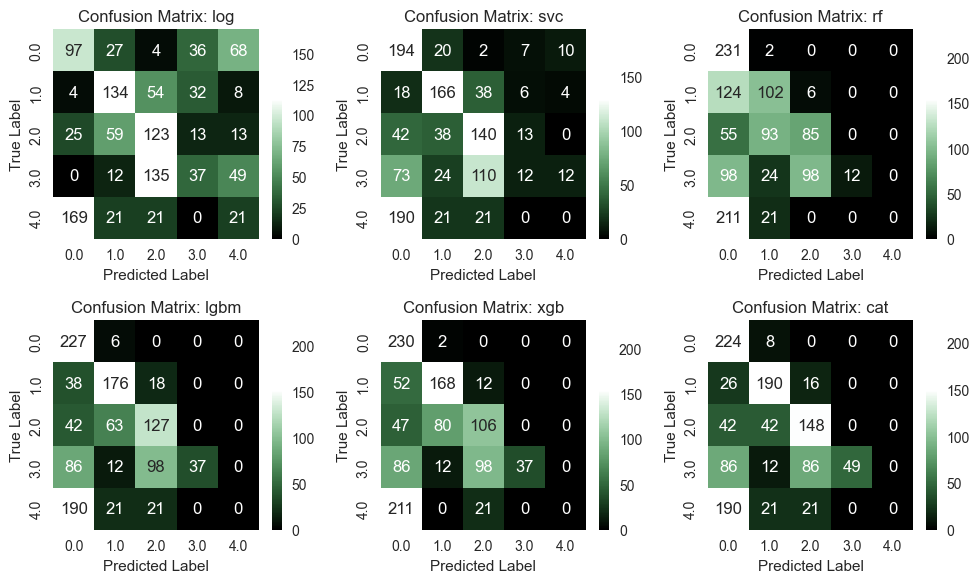


=== Train Metrics ===
Model  precision_score  recall_score  f1_score  accuracy  roc_auc
  log           0.3869        0.4068    0.3923    0.4068   0.7444
  svc           0.9109        0.9113    0.9104    0.9113   0.9313
   rf           1.0000        1.0000    1.0000    1.0000   1.0000
 lgbm           0.9997        0.9997    0.9997    0.9997   1.0000
  xgb           1.0000        1.0000    1.0000    1.0000   1.0000
  cat           0.9981        0.9981    0.9981    0.9981   0.9999

=== Test Metrics ===
Model  precision_score  recall_score  f1_score  accuracy  roc_auc
  log           0.3333        0.3541    0.3335    0.3541   0.6982
  svc           0.3528        0.4402    0.3565    0.4402   0.6368
   rf           0.4382        0.3697    0.2834    0.3697   0.7036
 lgbm           0.5005        0.4876    0.4060    0.4876   0.7214
  xgb           0.4909        0.4654    0.3878    0.4654   0.6842
  cat           0.5260        0.5257    0.4492    0.5257   0.7277


In [282]:
# Initial dataset (raw) analysis, without labels correction:
evaluate_model(models, X_train_raw, y_train_raw, X_test_raw, y_test_raw)

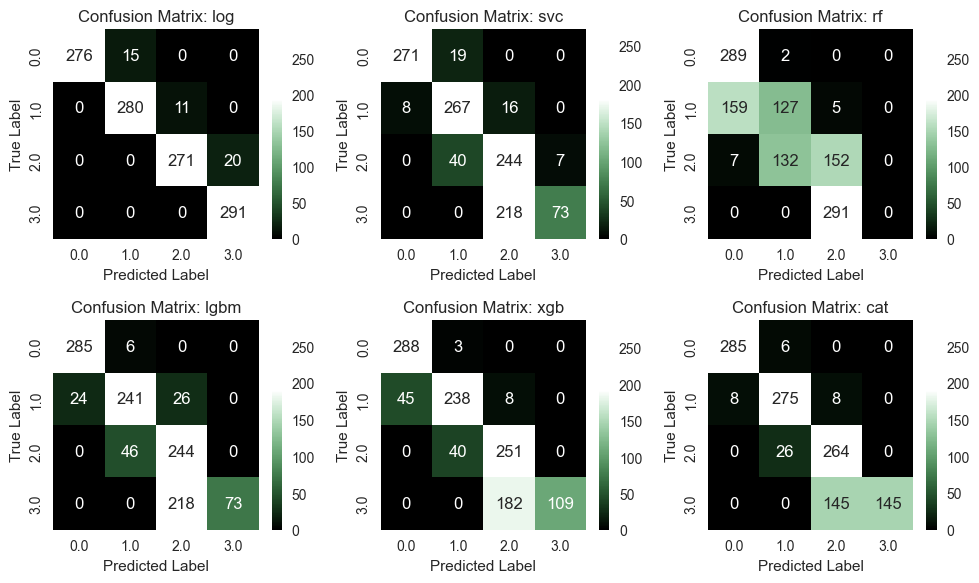


=== Train Metrics ===
Model  precision_score  recall_score  f1_score  accuracy  roc_auc
  log           0.9646        0.9638    0.9638    0.9638   0.9985
  svc           0.9824        0.9818    0.9818    0.9818   0.9999
   rf           1.0000        1.0000    1.0000    1.0000   1.0000
 lgbm           1.0000        1.0000    1.0000    1.0000   1.0000
  xgb           1.0000        1.0000    1.0000    1.0000   1.0000
  cat           0.9999        0.9999    0.9999    0.9999   1.0000

=== Test Metrics ===
Model  precision_score  recall_score  f1_score  accuracy  roc_auc
  log           0.9619        0.9609    0.9609    0.9609   0.9967
  svc           0.8045        0.7355    0.7115    0.7355   0.9456
   rf           0.3655        0.4883    0.4119    0.4883   0.8747
 lgbm           0.8115        0.7248    0.7008    0.7248   0.9403
  xgb           0.8207        0.7617    0.7471    0.7617   0.9303
  cat           0.8752        0.8336    0.8272    0.8336   0.9698


In [283]:
# Dataset analysis after labels correction:
evaluate_model(models, X_train, y_train, X_test, y_test)

Corrected dataset shows higher linear separablility, meaning simple linear decision boundaries work well.

This shows clearly how much of noise those 231 (~4%) wrongly categorized samples contribute. 

**EDA matched expectations:** 

* The lack of visual separability hinted that complex models would need to work harder to generalize.

* Tree-based ensemble models (especially CatBoost) proved to be most robust in practice — confirming the value of non-linear patterns picked up in SHAP.

* SVC and RF overfit — a common symptom when the model can't scale with class imbalance or data noise.

* Logistic regression surprisingly strong, possibly because the problem has some linear separability in high dimensions.

The best models are Logistic Regression and CatBoost Classifier.

### Hyperparameters tuning after classification correction
Logistic Regression, CatBoost Classifier

In [ ]:
def evaluate(best_model, X_train, y_train, X_test, y_test, model_name):
    """
    Evaluate the performance of a classification model.

    This function computes standard classification metrics on both
    training and test sets, displays a confusion matrix heatmap, and
    prints a classification report.

    Args:
        best_model: Trained classification model with predict and predict_proba methods.
        X_train (np.ndarray): Training feature matrix.
        y_train (np.ndarray): Training labels.
        X_test (np.ndarray): Test feature matrix.
        y_test (np.ndarray): Test labels.
        model_name (str): Identifier for the model.

    Returns:
        None
    """
    
    # Define evaluation metrics
    metrics = [precision_score, recall_score, f1_score]
    
    # Initialize storage for metrics
    scores_train = []
    scores_test = []
    
    # Compute balanced sample weights
    weights_train = compute_sample_weight(class_weight="balanced", y=y_train)
    weights_test = compute_sample_weight(class_weight="balanced", y=y_test)
    
    # Make predictions
    preds_train = best_model.predict(X_train)
    preds_test = best_model.predict(X_test)
    preds_proba_train = best_model.predict_proba(X_train)
    preds_proba_test = best_model.predict_proba(X_test)
    
    palette = sns.cubehelix_palette(
        start=2, rot=0, dark=0, light=1.5, reverse=True, as_cmap=True
    )

    # Initialize dictionaries for storing model scores
    model_scores_train = {"Model": model_name}
    model_scores_test = {"Model": model_name}

    # Compute precision, recall, f1-score
    for metric in metrics:
        model_scores_train[metric.__name__] = metric(
            y_train,
            preds_train,
            sample_weight=weights_train,
            average="weighted",
            zero_division=0,
        )
        model_scores_test[metric.__name__] = metric(
            y_test,
            preds_test,
            sample_weight=weights_test,
            average="weighted",
            zero_division=0,
        )

    model_scores_train["accuracy"] = accuracy_score(
        y_train, preds_train, sample_weight=weights_train
    )
    model_scores_test["accuracy"] = accuracy_score(
        y_test, preds_test, sample_weight=weights_test
    )

    # Compute ROC AUC for multi-class
    model_scores_train["roc_auc"] = roc_auc_score(
        y_train,
        preds_proba_train,
        sample_weight=weights_train,
        multi_class="ovr",
        average="weighted",
    )
    model_scores_test["roc_auc"] = roc_auc_score(
        y_test,
        preds_proba_test,
        sample_weight=weights_test,
        multi_class="ovr",
        average="weighted",
    )

    # Store results
    scores_train.append(model_scores_train)
    scores_test.append(model_scores_test)

    # Print classification report
    print("\n=== Classification Report ===")
    print(classification_report(y_test, preds_test))


    # Generate confusion matrix
    conf_matrix = confusion_matrix(y_test, preds_test, sample_weight=weights_test)


    # Plot confusion matrix
    sns.heatmap(
        conf_matrix,
        annot=True,
        cmap=palette,
        fmt=".0f",
        xticklabels=np.unique(y_test),
        yticklabels=np.unique(y_test),
    )
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix")
    plt.show()


    # Convert results to DataFrame and display
    results_df_train = pd.DataFrame(scores_train)
    results_df_test = pd.DataFrame(scores_test)
    
    # Print scores in tabular format
    print("\n=== Train Metrics ===")
    print(results_df_train.to_string(index=False, float_format="%.4f"))

    print("\n=== Test Metrics ===")
    print(results_df_test.to_string(index=False, float_format="%.4f"))

In [ ]:
# Model training using randomized grid search for training speed-up
def model_tuning(model, param_grid, n_iter):
    """
    Perform hyperparameter tuning using RandomizedSearchCV.

    Args:
        model: Estimator to be tuned.
        param_grid (dict): Dictionary of parameter distributions.
        n_iter (int): Number of parameter settings sampled.

    Returns:
        best_model: Estimator with the best found parameters.
    """
    folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

    # RandomizedSearchCV
    GS = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grid,
        n_iter=n_iter,
        scoring="f1_weighted",
        cv=folds,
        return_train_score=True,
        verbose=1,
        n_jobs=-1,  # Use all CPUs
        refit=True,
        random_state=SEED,
        error_score=0.0 # Silence completely
    )

    # Model taining and computing predictions
    GS.fit(X_train, y_train)
    best_model = GS.best_estimator_
    best_params = GS.best_params_
    print(f"Best Parameters: {best_params}")

    return best_model

#### Logistic Regression

Fitting 5 folds for each of 300 candidates, totalling 1500 fits
Best Parameters: {'solver': 'lbfgs', 'random_state': 42, 'penalty': 'l2', 'max_iter': 100, 'class_weight': None, 'C': 10000.0}

=== Classification Report ===
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1001
         1.0       1.00      1.00      1.00       110
         2.0       1.00      0.98      0.99        44
         3.0       0.89      1.00      0.94         8

    accuracy                           1.00      1163
   macro avg       0.97      0.99      0.98      1163
weighted avg       1.00      1.00      1.00      1163



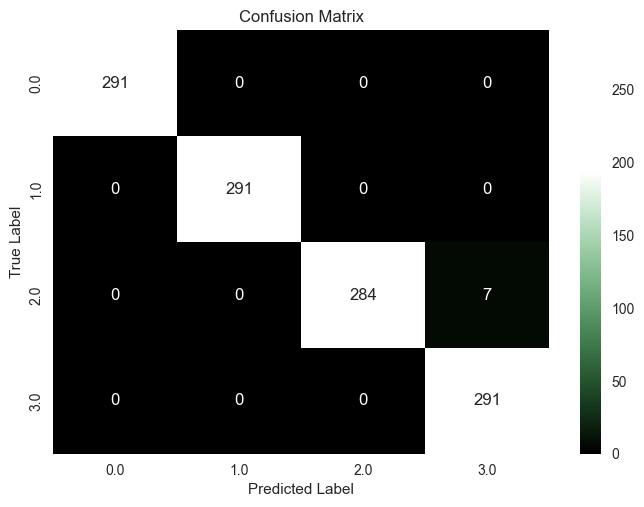


=== Train Metrics ===
    Model  precision_score  recall_score  f1_score  accuracy  roc_auc
class_Log           0.9986        0.9986    0.9986    0.9986   1.0000

=== Test Metrics ===
    Model  precision_score  recall_score  f1_score  accuracy  roc_auc
class_Log           0.9944        0.9943    0.9943    0.9943   1.0000

Search took 85.06 seconds.


In [ ]:
"""Logistic Regression model tuning and evaluation pipeline."""

model = LogisticRegression(random_state=SEED)
model_name = "class_Log"

start = time.time()

param_grid = {
    "penalty": ["l1", "l2", "elasticnet", None],
    "C": np.logspace(-4, 4, 10),
    "solver": ["liblinear", "lbfgs", "saga"],
    "max_iter": [100, 200, 500],
    "class_weight": [None, "balanced"],
    "random_state": [SEED],
}

n_iter = 300

best_model = model_tuning(model, param_grid, n_iter)
evaluate(best_model, X_train, y_train, X_test, y_test, model_name)

print("\nSearch took %.2f seconds." % (time.time() - start))

filename = f"{model_name}.sav"
pickle.dump(best_model, open(f"../models/{filename}", "wb"))


After Logistic Regression hyperparameters tuning metrics improved.

#### CatBoost

*Early stopping is an important technique in both classification and regression tasks when using CatBoost and LightGBM, as it helps prevent overfitting by stopping training when the model's performance on a validation set stops improving*

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Parameters: {'learning_rate': 0.3, 'l2_leaf_reg': 0.1, 'iterations': 1000, 'depth': 3}

=== Classification Report ===
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      1001
         1.0       0.86      0.93      0.89       110
         2.0       0.87      0.93      0.90        44
         3.0       0.83      0.62      0.71         8

    accuracy                           0.98      1163
   macro avg       0.89      0.87      0.87      1163
weighted avg       0.98      0.98      0.98      1163



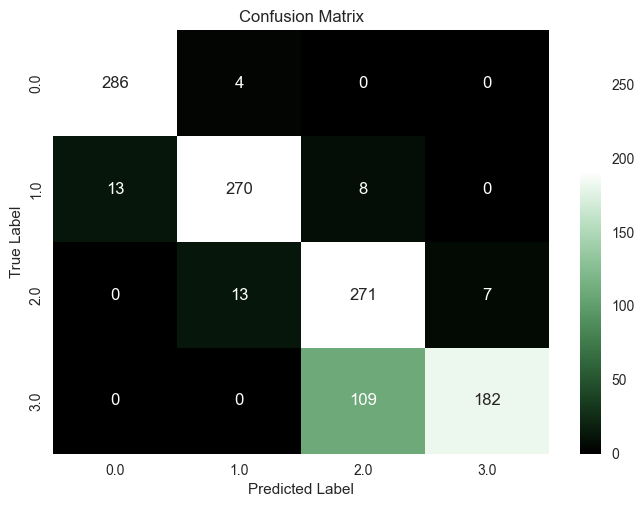


=== Train Metrics ===
         Model  precision_score  recall_score  f1_score  accuracy  roc_auc
class_CatBoost           1.0000        1.0000    1.0000    1.0000   1.0000

=== Test Metrics ===
         Model  precision_score  recall_score  f1_score  accuracy  roc_auc
class_CatBoost           0.8895        0.8673    0.8651    0.8673   0.9823

Search took 132.77 seconds.


In [ ]:
"""CatBoost model tuning and evaluation."""

model = CatBoostClassifier(
    verbose=0,
    random_state=SEED,
    early_stopping_rounds=50,
    auto_class_weights="Balanced",
)

model_name = "class_CatBoost"
start = time.time()

param_grid = {
    "iterations": [1000],
    "learning_rate": [0.3, 0.4, 0.5],
    "depth": [1, 3, 6],
    "l2_leaf_reg": [0.1, 0.5, 0.8],
}

n_iter = 100

best_model = model_tuning(model, param_grid, n_iter)
evaluate(best_model, X_train, y_train, X_test, y_test, model_name)

print("\nSearch took %.2f seconds." % (time.time() - start))

filename = f"{model_name}.sav"
pickle.dump(best_model, open(f"../models/{filename}", "wb"))

**ML Classification Conclusion**

* Tuned Logistic Regression significantly improved and delivered near-perfect metrics.
* Tuned CatBoost still strong, but didn't outperform logistic in this case.

Although CatBoost is generally more flexible and resilient to data irregularities, in this project Logistic Regression not only performed better but also showed excellent generalization — making it the stronger choice here.

# Regression
Regression using HealthImpactScore

## EDA

In [ ]:
# Dataset with corrected classes
file_path = "https://raw.githubusercontent.com/Zanyata/Air_Quality/refs/heads/main/data/air_quality_health_impact_data.csv"

df = load_data(file_path)
df = classification_correction(df)

strat_train_set, strat_test_set, feature_names = stratify_splitting(df)
X_train, y_train, X_test, y_test = xy_splitting_scaling(
    strat_train_set, strat_test_set, "HealthImpactScore"
)

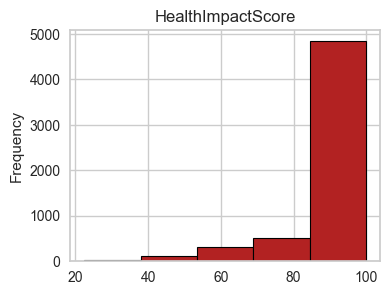

In [295]:
# Histogram of HealthImpactScore
plt.figure(figsize=(4, 3))
df["HealthImpactScore"].plot(
    kind="hist",
    bins=5,
    title="HealthImpactScore",
    color="firebrick",
    edgecolor="black",
    linewidth=0.8,
)
plt.show()

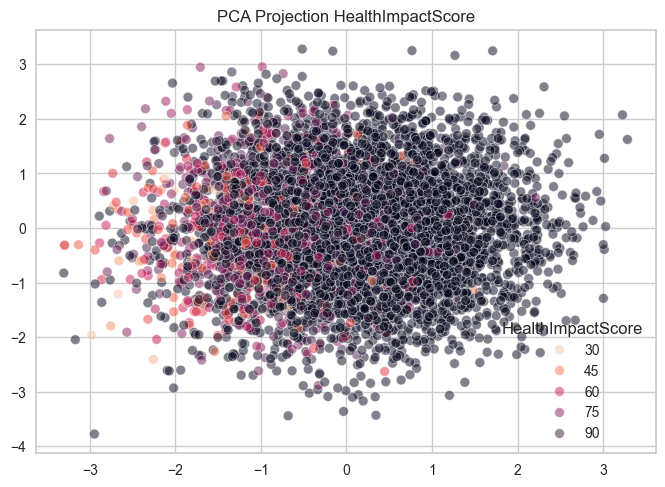

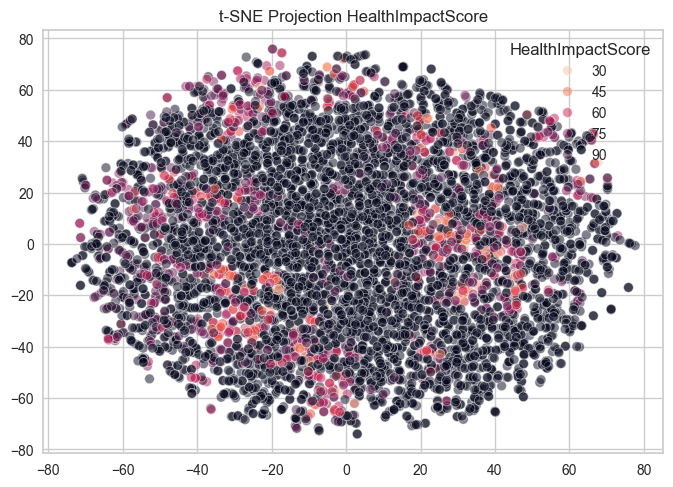

In [301]:
def visualize_dimensionality_reduction(df, target_col):
    """Visualize separability using PCA and t-SNE."""
    features = df.drop(columns=["HealthImpactScore", "HealthImpactClass"])
    y = df[target_col]
    X_scaled = StandardScaler().fit_transform(features.select_dtypes(include=np.number))

    # PCA projection
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)
    sns.scatterplot(
        x=X_pca[:, 0],
        y=X_pca[:, 1],
        hue=y,
        palette=sns.color_palette("rocket_r", as_cmap=True),
        alpha=0.5,
        edgecolor="white",
    )
    plt.title(f"PCA Projection {y.name}")
    plt.show()

    # t-SNE projection
    tsne = TSNE(n_components=2, perplexity=30, learning_rate=200)
    X_tsne = tsne.fit_transform(X_scaled)
    sns.scatterplot(
        x=X_tsne[:, 0],
        y=X_tsne[:, 1],
        hue=y,
        palette=sns.color_palette("rocket_r", as_cmap=True),
        alpha=0.5,
        edgecolor="white",
    )
    plt.title(f"t-SNE Projection {y.name}")
    plt.show()


visualize_dimensionality_reduction(df, "HealthImpactScore")

*Same as for classification* 

**PCA (Regression)**

* Regression values (continuous hue) don’t form a clear gradient.

* Again, weak linear separability.

**t-SNE (Regression)**

* Slightly better: some pockets of similar values are near each other.


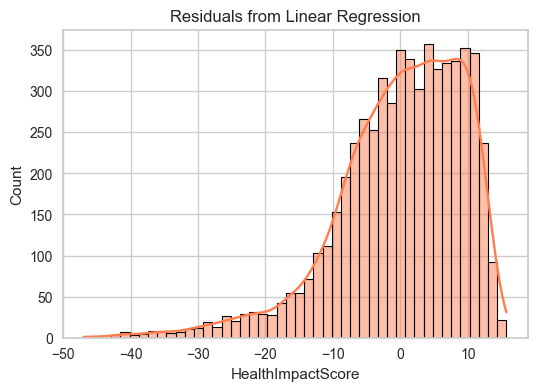

MSE: 89.77984597036519


In [ ]:
# Residual analysis from linear regression
features = df.drop(columns=["HealthImpactScore", "HealthImpactClass"])
y = df["HealthImpactScore"]
X_scaled = StandardScaler().fit_transform(features.select_dtypes(include=np.number))

if y.nunique() > 10:
    linreg = LinearRegression()
    linreg.fit(X_scaled, y)
    preds = linreg.predict(X_scaled)
    residuals = y - preds

    plt.figure(figsize=(6, 4))
    sns.histplot(
        residuals,
        kde=True,
        color="coral",
        edgecolor="black",
        linewidth=0.8
    )
    plt.title("Residuals from Linear Regression")
    plt.show()

    print("MSE:", mean_squared_error(y, preds))

**Residuals Plot**

Model over-predicts at low target values.

Residuals are skewed.

<Axes: >

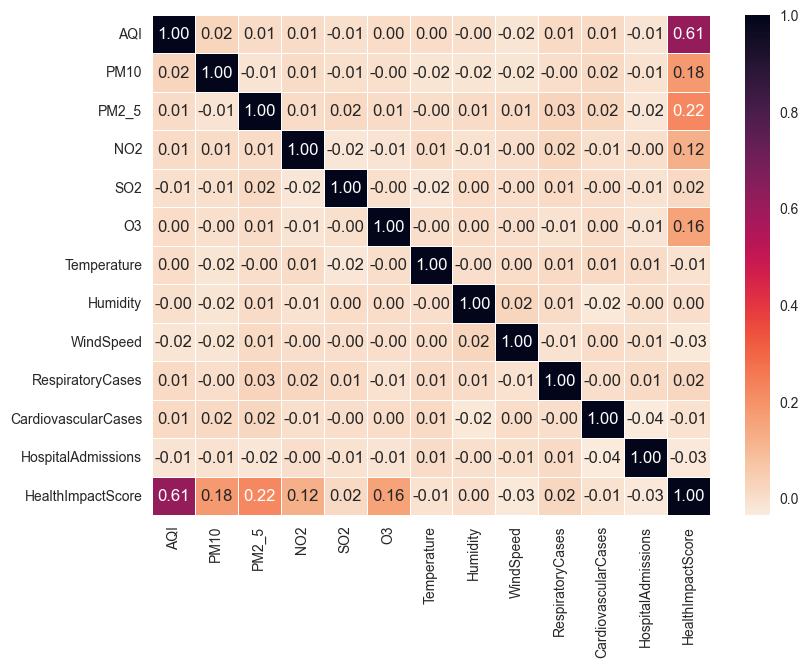

In [312]:
# Correlation Heatmap
plt.figure(figsize=(9,6.5))
sns.heatmap(df.drop(columns="HealthImpactClass").corr(),annot=True,linewidths=0.5,fmt='.2f',cmap="rocket_r")

The correlation heatmap reveals a moderate positive correlation between the target variable HealthImpactScore and AQI (r ≈ 0.61), suggesting AQI is a strong predictor.

The higher absolute value (|0.61|) in regression implies that HealthImpactScore captures a slightly stronger linear relationship with AQI compared to the classification target.

Both targets capture similar relationships with features, but the signs differ due to label encoding. The regression target (HealthImpactScore) directly scales with impact, while the classification target (HealthImpactClass) is inversely related due to the bin labeling.

All remaining features (e.g., weather and health indicators) still exhibit very weak or negligible correlations with the target.

Multicollinearity between features appears minimal, as there are no high correlations between independent variables. This is favorable for most ML models and ensures model stability and interpretability.

## ML

### Model Benchmarking

In [316]:
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "Polynomial Regression3": Pipeline(
        [("poly", PolynomialFeatures(degree=3)), ("lr", LinearRegression())]
    ),
    "SVR": SVR(),
    "Random Forest": RandomForestRegressor(),
    "LightGBM": LGBMRegressor(),
    "XGBoost": XGBRegressor(),
    "CatBoost": CatBoostRegressor(verbose=0),
}

In [ ]:
def evaluate_model_reg(models, X_train, y_train, X_test, y_test):
    """
    Evaluate regression models on training and test data.

    Args:
        models (dict): Dictionary of model names and instantiated models.
        X_train (array): Training feature set.
        y_train (array): Training targets.
        X_test (array): Test feature set.
        y_test (array): Test targets.
    """
    
    # Define evaluation metrics
    metrics = [mean_absolute_error, rmse, r2_score]
    
    # Initialize storage for metrics
    scores_train = []
    scores_test = []
    
    plt.figure(figsize=(12, 8))

    # Compute mean_absolute_error, rmse, r2_score
    for i, (name, model) in enumerate(models.items()):
        model.fit(X_train, y_train)
        preds_train = model.predict(X_train)
        preds_test = model.predict(X_test)

        model_scores_train = {"Model": name}
        model_scores_test = {"Model": name}
        for metric in metrics:
            model_scores_train[metric.__name__] = metric(
                y_train,
                preds_train,
            )
            model_scores_test[metric.__name__] = metric(
                y_test,
                preds_test,
            )
            
        # Store results
        scores_train.append(model_scores_train)
        scores_test.append(model_scores_test)
        
        # Scatter plot for actual vs predicted values
        plt.subplot(4, 3, i + 1)  # Adjusting for more models
        plt.scatter(y_test, preds_test, alpha=0.5, color="sandybrown", edgecolors="k")
        plt.plot(
            [y_test.min(), y_test.max()],
            [y_test.min(), y_test.max()],
            color="darkred",
            linestyle="--",
        )
        plt.xlabel("Actual Values")
        plt.ylabel("Predicted Values")
        plt.title(f"{name}: Actual vs Predicted")

    plt.tight_layout()
    plt.show()

    # Convert results to DataFrame and display
    results_df_train = pd.DataFrame(scores_train)
    results_df_test = pd.DataFrame(scores_test)

    # Print scores in tabular format
    print("\n=== Train Metrics ===")
    print(results_df_train.to_string(index=False, float_format="%.4f"))

    print("\n=== Test Metrics ===")
    print(results_df_test.to_string(index=False, float_format="%.4f"))

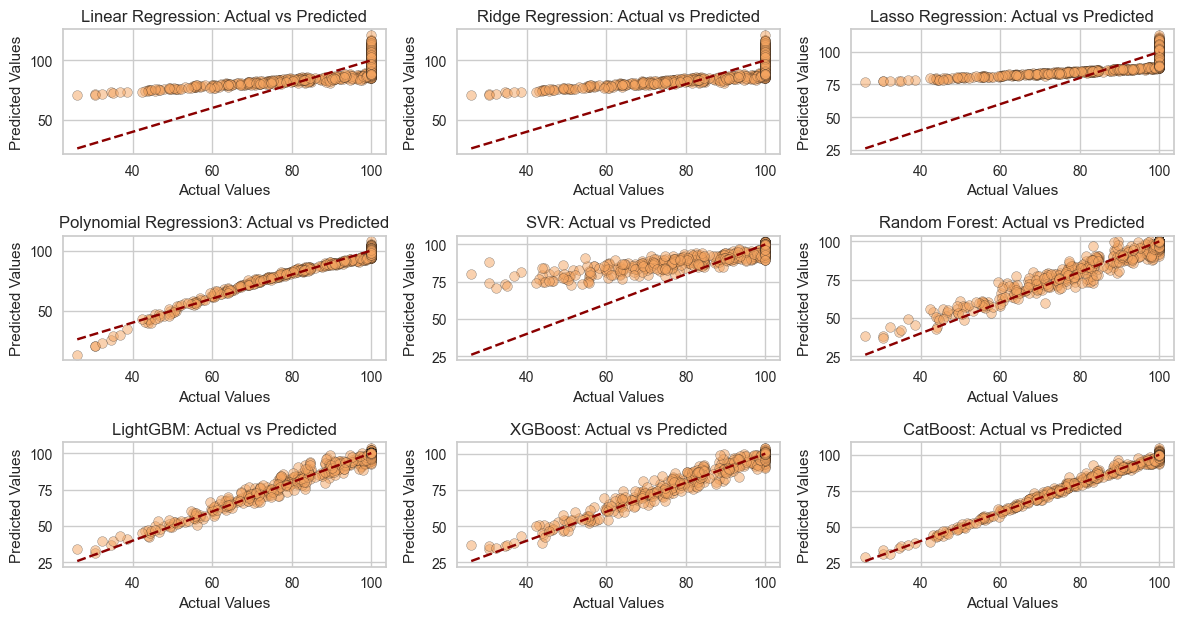


=== Train Metrics ===
                 Model  mean_absolute_error   rmse  r2_score
     Linear Regression               7.3384 9.4485    0.4949
      Ridge Regression               7.3380 9.4485    0.4949
      Lasso Regression               7.0620 9.7181    0.4657
Polynomial Regression3               1.5334 2.0532    0.9761
                   SVR               4.2350 8.4162    0.5992
         Random Forest               0.5285 1.1368    0.9927
              LightGBM               0.3628 0.6996    0.9972
               XGBoost               0.1444 0.2427    0.9997
              CatBoost               0.3388 0.5486    0.9983

=== Test Metrics ===
                 Model  mean_absolute_error   rmse  r2_score
     Linear Regression               7.4195 9.5948    0.4880
      Ridge Regression               7.4191 9.5948    0.4880
      Lasso Regression               7.0998 9.8120    0.4646
Polynomial Regression3               1.7931 2.3469    0.9694
                   SVR               4.4

In [339]:
evaluate_model_reg(models, X_train, y_train, X_test, y_test)

Best models CatBoost Regressor, LGBM Regressor, Polynomial Regression deg.3

Linear, Ridge, and Lasso Regression models showed significantly higher MAE and RMSE, indicating that they are not suitable for this dataset.

SVR showed moderate performance but lagged behind boosting methods.

### Hyperparameters tuning

In [ ]:
# Model training using randomized grid search for training speed-up
def model_tuning_reg(model, param_grid, n_iter):
    """
    Perform hyperparameter tuning using RandomizedSearchCV.

    Args:
        model: Estimator to be tuned.
        param_grid (dict): Dictionary of parameter distributions.
        n_iter (int): Number of parameter settings sampled.

    Returns:
        best_model: Estimator with the best found parameters.
    """
    folds = KFold(n_splits=5, shuffle=True, random_state=SEED)

    # RandomizedSearchCV
    GS = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grid,
        n_iter=n_iter,
        scoring="neg_mean_squared_error",
        cv=folds,
        return_train_score=True,
        verbose=1,
        n_jobs=-1,  # Use all CPUs
        refit=True,
        random_state=SEED,
        error_score=0.0 # Silence completely
    )

    # Model taining and computing predictions
    GS.fit(X_train, y_train)
    best_model = GS.best_estimator_
    best_params = GS.best_params_
    print(f"Best Parameters: {best_params}")

    return best_model

In [ ]:
def evaluate_reg(best_model, X_train, y_train, X_test, y_test, model_name):
    """
    Evaluate the performance of a regression model.

    This function computes standard regression metrics on both
    training and test sets, displays a confusion matrix heatmap.

    Args:
        best_model: Trained regression model with predict.
        X_train (np.ndarray): Training feature matrix.
        y_train (np.ndarray): Training labels.
        X_test (np.ndarray): Test feature matrix.
        y_test (np.ndarray): Test labels.
        model_name (str): Identifier for the model.

    Returns:
        None
    """
    
    # Define evaluation metrics
    metrics = [mean_absolute_error, rmse, r2_score]
    
    # Initialize storage for metrics
    scores_train = []
    scores_test = []
    
    # Make predictions
    preds_train = best_model.predict(X_train)
    preds_test = best_model.predict(X_test)

    # Initialize dictionaries for storing model scores
    model_scores_train = {"Model": model_name}
    model_scores_test = {"Model": model_name}
    
    for metric in metrics:
        model_scores_train[metric.__name__] = metric(
            y_train,
            preds_train,
        )
        model_scores_test[metric.__name__] = metric(
            y_test,
            preds_test,
        )
        
    # Store results
    scores_train.append(model_scores_train)
    scores_test.append(model_scores_test)
    
    # Scatter plot for actual vs predicted values
    plt.figure(figsize=(10,6))
    plt.scatter(y_test, preds_test, alpha=0.5, color="sandybrown", edgecolors="k")
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='darkred', linestyle='--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title("Actual vs Predicted")
    plt.show()
    
    # Convert results to DataFrame and display
    results_df_train = pd.DataFrame(scores_train)
    results_df_test = pd.DataFrame(scores_test)

    # Print scores in tabular format
    print("\n=== Train Metrics ===")
    print(results_df_train.to_string(index=False, float_format="%.4f"))

    print("\n=== Test Metrics ===")
    print(results_df_test.to_string(index=False, float_format="%.4f"))

#### Polynomial Regression

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best Parameters: {'ridge__alpha': 10, 'poly__interaction_only': False, 'poly__include_bias': False, 'poly__degree': 3}


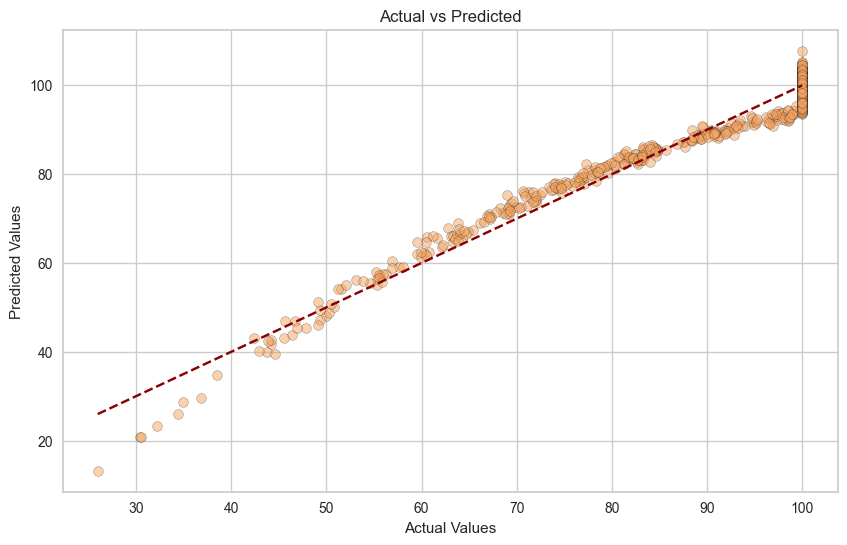


=== Train Metrics ===
   Model  mean_absolute_error   rmse  r2_score
reg_Poly               1.5328 2.0534    0.9761

=== Test Metrics ===
   Model  mean_absolute_error   rmse  r2_score
reg_Poly               1.7908 2.3450    0.9694

Search took 11.02 seconds.


In [ ]:
# Polynomial regression with Ridge regularization and randomized search.

model = Pipeline([
    ("poly", PolynomialFeatures()),
    ("ridge", Ridge()),
])

model_name = "reg_Poly"

start = time.time()

param_grid = {
    "poly__interaction_only": [False, True],
    "poly__include_bias": [False, True],
    "poly__degree": [2, 3, 4],
    "ridge__alpha": [0.01, 0.1, 1, 10, 100],
}

n_iter = 100

best_model = model_tuning_reg(model, param_grid, n_iter)

evaluate_reg(best_model, X_train, y_train, X_test, y_test, model_name)

print("\nSearch took %.2f seconds." % (time.time() - start))

filename = f"{model_name}.sav"
pickle.dump(best_model, open(f"../models/{filename}", "wb"))

#### LGBM

Fitting 5 folds for each of 300 candidates, totalling 1500 fits
Best Parameters: {'subsample': 0.7, 'reg_lambda': 0.05, 'reg_alpha': 0.1, 'num_leaves': 20, 'n_estimators': 1000, 'min_split_gain': 0.01, 'min_child_samples': 30, 'max_depth': 20, 'learning_rate': 0.08, 'colsample_bytree': 1.0}


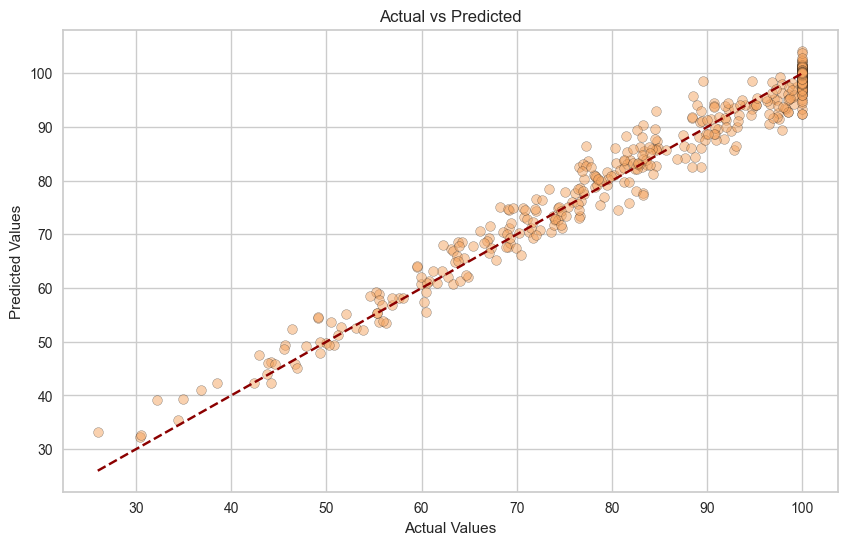


=== Train Metrics ===
   Model  mean_absolute_error   rmse  r2_score
reg_LGBM               0.1531 0.2461    0.9997

=== Test Metrics ===
   Model  mean_absolute_error   rmse  r2_score
reg_LGBM               0.9289 1.8036    0.9819

Search took 311.85 seconds.


In [ ]:
# LGBMRegressor with randomized hyperparameter tuning and evaluation.

model = LGBMRegressor(random_state=SEED)
model_name = "reg_LGBM"

start = time.time()

param_grid = {
    "n_estimators": [500, 1000],
    "learning_rate": [0.01, 0.03, 0.05, 0.08],
    "max_depth": [-1, 10, 15, 20],
    "num_leaves": [20, 30, 40, 60],
    "min_child_samples": [5, 10, 20, 30, 50],
    "subsample": [0.6, 0.7, 0.8, 0.9],
    "colsample_bytree": [0.6, 0.8, 0.95, 1.0],
    "reg_alpha": [0, 0.01, 0.05, 0.1, 0.5],
    "reg_lambda": [0, 0.01, 0.05, 0.1, 0.5],
    "min_split_gain": [0.0, 0.01, 0.1],
}

n_iter = 300

best_model = model_tuning_reg(model, param_grid, n_iter)
evaluate_reg(best_model, X_train, y_train, X_test, y_test, model_name)

print("\nSearch took %.2f seconds." % (time.time() - start))

filename = f"{model_name}.sav"
pickle.dump(best_model, open(f"../models/{filename}", "wb"))

#### CatBoost Regressor

Fitting 5 folds for each of 150 candidates, totalling 750 fits
Best Parameters: {'subsample': 1.0, 'random_strength': 1, 'loss_function': 'RMSE', 'learning_rate': 0.03, 'l2_leaf_reg': 1, 'iterations': 1000, 'depth': 6}


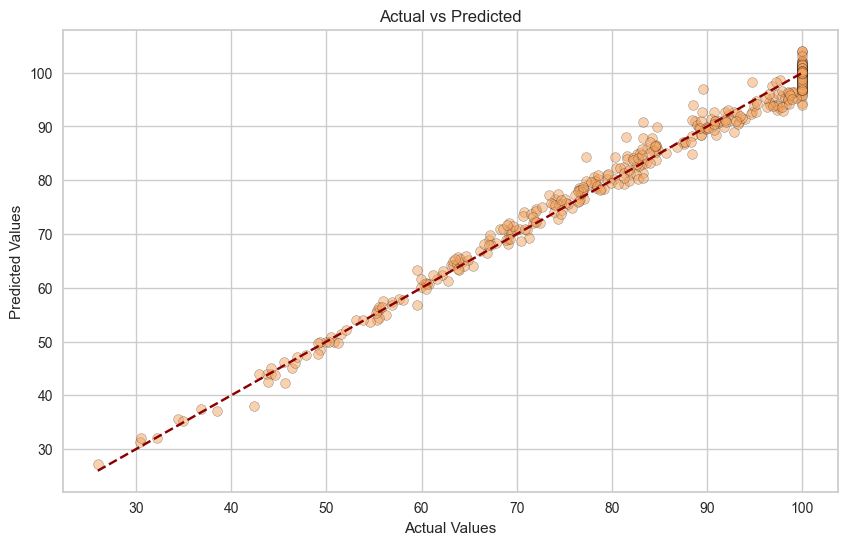


=== Train Metrics ===
       Model  mean_absolute_error   rmse  r2_score
reg_CatBoost               0.4041 0.6731    0.9974

=== Test Metrics ===
       Model  mean_absolute_error   rmse  r2_score
reg_CatBoost               0.6761 1.2330    0.9915

Search took 2110.94 seconds.


In [ ]:
# CatBoostRegressor with randomized hyperparameter tuning and evaluation.

model = CatBoostRegressor(
    verbose=0,
    random_state=SEED,
    early_stopping_rounds=50
)

model_name = "reg_CatBoost"
start = time.time()

param_grid = {
    "iterations": [500, 800, 1000],
    "learning_rate": [0.01, 0.03, 0.05, 0.1],
    "depth": [4, 6, 8, 10],
    "l2_leaf_reg": [1, 2, 3, 5, 10],
    "subsample": [0.9, 1.0],
    "random_strength": [1, 5, 10],
    "loss_function": ["RMSE", "MAE"],
}

n_iter = 150

best_model = model_tuning_reg(model, param_grid, n_iter)
evaluate_reg(best_model, X_train, y_train, X_test, y_test, model_name)

print("\nSearch took %.2f seconds." % (time.time() - start))

filename = f"{model_name}.sav"
pickle.dump(best_model, open(f"../models/{filename}", "wb"))

**Conclusion**

* Polynomial Regression is fast and accurate — a great lightweight option.
* LGBM offers better accuracy than Polynomial with moderate training time.
* CatBoost is the most accurate model overall, but takes the longest to train.

# NN Classification

Given the issues with matching ML algorithm to this classification problem, it's a good idea to check performance of very simple NN model.

In [ ]:
# Dataset with corrected classes, get validation set
file_path = "https://raw.githubusercontent.com/Zanyata/Air_Quality/refs/heads/main/data/air_quality_health_impact_data.csv"

df = load_data(file_path)
df = classification_correction(df)

strat_train_set, strat_test_set, feature_names = stratify_splitting(df)

# Validation set added
strat_train_set, strat_val_set, feature_names = stratify_splitting(strat_train_set)

X_train, y_train, X_test, y_test = xy_splitting_scaling(
    strat_train_set, strat_test_set, "HealthImpactClass"
)

# Validation set added
X_val = strat_val_set.drop(columns=["HealthImpactScore", "HealthImpactClass"])
y_val = strat_val_set["HealthImpactClass"].values
scaler = StandardScaler()
X_val = scaler.fit_transform(X_val)

In [ ]:
def evaluate_nn(preds_proba_train, preds_train, preds_proba_test, preds_test,
                y_train, y_test, model_name):
    """
    Evaluate a trained neural network classifier using various metrics.

    This function computes weighted precision, recall, F1 score, accuracy, and
    ROC-AUC for both training and test sets. It also displays a classification
    report and confusion matrix.

    Args:
        preds_proba_train (ndarray): Predicted probabilities on training data.
        preds_train (ndarray): Predicted class labels on training data.
        preds_proba_test (ndarray): Predicted probabilities on test data.
        preds_test (ndarray): Predicted class labels on test data.
        y_train (ndarray): Ground truth labels for training set.
        y_test (ndarray): Ground truth labels for test set.
        model_name (str): Name of the evaluated model.
    """
    metrics = [precision_score, recall_score, f1_score]
    scores_train = []
    scores_test = []

    # Handle class imbalance using balanced weights
    weights_train = compute_sample_weight(class_weight="balanced", y=y_train)
    weights_test = compute_sample_weight(class_weight="balanced", y=y_test)

    # Custom colormap for visualizing confusion matrix
    palette = sns.cubehelix_palette(
        start=2, rot=0, dark=0, light=1.5, reverse=True, as_cmap=True
    )

    model_scores_train = {"Model": model_name}
    model_scores_test = {"Model": model_name}

    # Compute evaluation metrics for both train and test sets
    for metric in metrics:
        model_scores_train[metric.__name__] = metric(
            y_train,
            preds_train,
            sample_weight=weights_train,
            average="weighted",
            zero_division=0,
        )
        model_scores_test[metric.__name__] = metric(
            y_test,
            preds_test,
            sample_weight=weights_test,
            average="weighted",
            zero_division=0,
        )

    model_scores_train["accuracy"] = accuracy_score(
        y_train, preds_train, sample_weight=weights_train
    )
    model_scores_test["accuracy"] = accuracy_score(
        y_test, preds_test, sample_weight=weights_test
    )

    # ROC-AUC for multiclass classification
    model_scores_train["roc_auc"] = roc_auc_score(
        y_train,
        preds_proba_train,
        sample_weight=weights_train,
        multi_class="ovr",
        average="weighted",
    )
    model_scores_test["roc_auc"] = roc_auc_score(
        y_test,
        preds_proba_test,
        sample_weight=weights_test,
        multi_class="ovr",
        average="weighted",
    )

    scores_train.append(model_scores_train)
    scores_test.append(model_scores_test)

    # Classification report for test set
    print("\n=== Classification Report ===")
    print(classification_report(y_test, preds_test))

    # Confusion matrix plot
    conf_matrix = confusion_matrix(y_test, preds_test, sample_weight=weights_test)
    sns.heatmap(
        conf_matrix,
        annot=True,
        cmap=palette,
        fmt=".0f",
        xticklabels=np.unique(y_test),
        yticklabels=np.unique(y_test),
    )
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

    # Display metric results
    results_df_train = pd.DataFrame(scores_train)
    results_df_test = pd.DataFrame(scores_test)

    print("\n=== Train Metrics ===")
    print(results_df_train.to_string(index=False, float_format="%.4f"))

    print("\n=== Test Metrics ===")
    print(results_df_test.to_string(index=False, float_format="%.4f"))

In [ ]:
def plot_history(history):
    """
    Plot training history of accuracy and loss.

    Args:
        history (History): Keras History object from model.fit().
    """
    print(history.history.keys())
    print()

    # Accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

    # Loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()


In [ ]:
# Neural network model definition using Sequential API.

input_dim = X_train.shape[1]

model = tf.keras.Sequential([
    Input(shape=(input_dim,)),
    tf.keras.layers.Dense(64),
    LeakyReLU(negative_slope=0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.01),

    tf.keras.layers.Dense(32, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    LeakyReLU(negative_slope=0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.01),

    tf.keras.layers.Dense(units=len(np.unique(y_train)), activation="softmax"),
])


In [76]:
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_23 (Dense)                │ (None, 36)             │           468 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 36)             │         1,332 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 36)             │           144 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 36)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 4)              │           148 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,134 (23.96 KB)

 Trainable params: 2,020 (7.89 KB)

 Non-trainable params: 72 (288.00 B)

 Optimizer params: 4,042 (15.79 KB)

Epoch 30: early stopping
Restoring model weights from the end of the best epoch: 15.
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9617 - loss: 0.1111 

=== Classification Report ===
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99      1001
         1.0       0.88      0.81      0.84       110
         2.0       0.72      0.77      0.75        44
         3.0       0.57      0.50      0.53         8

    accuracy                           0.97      1163
   macro avg       0.79      0.77      0.78      1163
weighted avg       0.97      0.97      0.97      1163



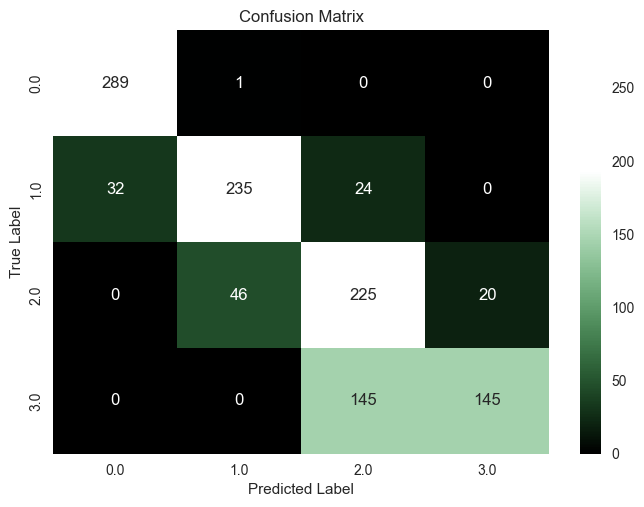


=== Train Metrics ===
Model  precision_score  recall_score  f1_score  accuracy  roc_auc
   NN           0.9763        0.9761    0.9761    0.9761   0.9990

=== Test Metrics ===
Model  precision_score  recall_score  f1_score  accuracy  roc_auc
   NN           0.7958        0.7692    0.7650    0.7692   0.9526
dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])



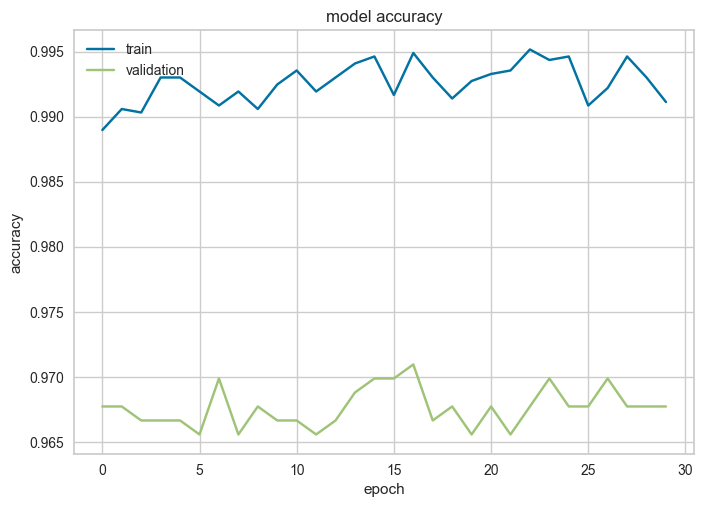

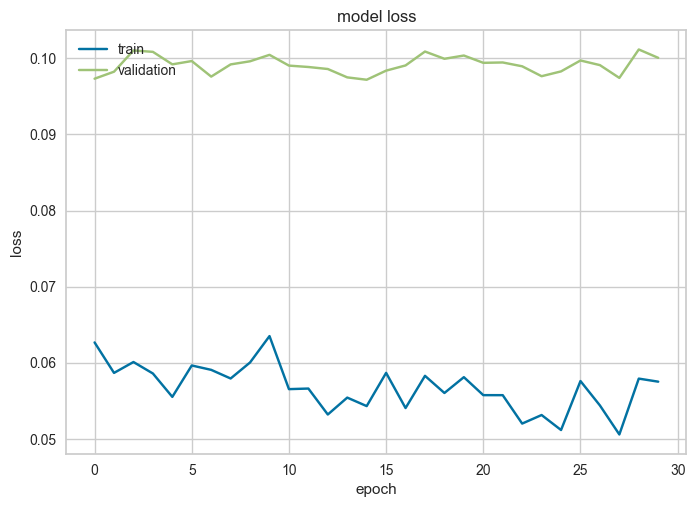

In [ ]:
# Compile, train, evaluate, and save a neural network model.

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, weight_decay=1e-5)
model.compile(optimizer=optimizer, metrics=["accuracy"], loss="sparse_categorical_crossentropy")

model_name = "NN"

# Early Stopping definition
early_stopping = EarlyStopping(
    monitor="val_loss",
    verbose=1,
    patience=15,
    restore_best_weights=True,
)

# Model training
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    batch_size=64,
    epochs=200,
    callbacks=[early_stopping],
    verbose=0,
)


# Predict probabilities
preds_proba_train = model.predict(X_train)
# Convert probabilities to class labels
preds_train = np.argmax(
    preds_proba_train, axis=1
)

# Predict probabilities
preds_proba_test = model.predict(X_test)
# Convert probabilities to class labels
preds_test = np.argmax(
    preds_proba_test, axis=1
)


model.evaluate(X_test, y_test)


evaluate_nn(preds_proba_train, preds_train, preds_proba_test, preds_test, y_train, y_test, model_name)

plot_history(history)

model.save("../models/NNmodel_2.h5")

Despite tuning and regularization efforts, the neural network shows inconsistent performance across multiple training runs. As deep learning models typically require larger datasets to reach their full potential this model was discarded. 

# Model Selection and Conclusion

Classification models (especially Logistic Regression) performed exceptionally well with almost perfect accuracy.

Regression models offered more granular predictions with strong R² scores, especially with CatBoost.

- If prediction granularity is important (e.g. estimating actual scores), regression is preferable.

- If interpretable categories or fast inference is key, classification (esp. Logistic Regression) is a great fit.

No single metric can directly compare regression and classification models, because they solve different problems and their outputs are fundamentally different.
But both models are performing at a very high level on their respective tasks, neither modeling strategy demonstrated a clear superiority.